# Neural Headline Generation Metrics & Comparisons
Although human judgment is the gold standard for assessing the quality of summarization outputs, there are several metrics and comparisons we can gather automatically.
In this notebook, we will compare a neural headline generation model with metrics previously reported in these arxiv.org papers:
    1. Neural Headline Generation with Sentence-wise Optimization by Ayana, Shiqi Shen, Yu Zhao, Zhiyuan Liu, Maosong Sun https://arxiv.org/abs/1604.01904
    2. This Email Could Save Your Life: Introducing the Task of Email Subject Line Generation by Rui Zhang, Joel Tetreault https://arxiv.org/abs/1906.03497)
    3. Low-Resource Neural Headline Generation by Ottokar Tilk, Tanel Alumäe https://arxiv.org/abs/1707.09769
    4. HEADS: Headline Generation as Sequence Prediction Using an Abstract Feature-Rich Space by Carlos A. Colmenares, Marina Litvak, +1 author Fabrizio Silvestri https://www.semanticscholar.org/paper/HEADS%3A-Headline-Generation-as-Sequence-Prediction-Colmenares-Litvak/a9614b05461bb306cc47c8cd645b9b67bb1227ba
    5. Neural Headline Generation on Abstract Meaning Representation by Sho Takase, Jun Suzuki, +2 authors Masaaki Nagata https://www.semanticscholar.org/paper/Neural-Headline-Generation-on-Abstract-Meaning-Takase-Suzuki/4d1f12f1a28afc30aab6f5086b3f2e481cf1f49f)
    
We will also examine performance with respect to several baseline heuristics detailed in the first paper, namely:
* TfIdf (top 8 keywords)
* original title

The model under consideration is a fine-tuned BERT model trained to predict the words of a headline representing a given document. The implementation and the results here are based on several Archiv papers.

In [1]:
%matplotlib inline
from matplotlib.pyplot import hist

In [2]:
import statistics
import re

import pandas as pd
from nltk import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

In [3]:
headlines_df = pd.read_csv('headline_generation.sample.csv', sep='\t')
headlines_df.head()

,title_original,title_generated,text
0,U.S. Informs Iraqi Government About Reposition...,Some Forces Being Repositioned Inside Iraq,Secretary of Defense Mark Esper announced on M...
1,Ayatollah Weeps And Iranians Rail Against U.S....,Qassem Soleimani The Commander Of Iran's Elite,Vast crowds thronged the streets of Tehran on ...
2,Investor's Naked Selfies Ignite #MeToo Moment:...,Venture Capital Investors Influence Over Startup,"""People would assume that my male colleague wa..."
3,Harvey Weinstein Is Charged With Sexual Assaul...,Harvey Weinstein Charged With Sexual Assault,Harvey Weinstein was charged with four felony...
4,Australia Wildfires Have Claimed 25 Lives And ...,Deaths Reported In New South,While conditions improved slightly over the we...


### Rouge recall:
#### number of overlapping words / number of words in reference summary

Using unigrams is the simplest baseline, others are available https://en.wikipedia.org/wiki/ROUGE_(metric)

### Generated Headlines compared to original titles, Rouge-1 recall

Generated Headlines compared to original titles, Rouge-1 recall
mean: 0.3490199638492307, stddev 0.2567401783811817


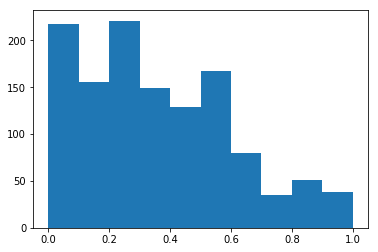

In [4]:
vals =[]
for idx, row in headlines_df.iterrows():
    title_original_words = word_tokenize(row['title_original'].lower())
    title_generated_words = word_tokenize(row['title_generated'].lower())
    title_original_words = [stemmer.stem(word) for word in title_original_words]
    title_generated_words = [stemmer.stem(word) for word in title_generated_words]
    vals.append(len(set(title_generated_words) & set(title_original_words)) / len(title_generated_words))
hist(vals, bins=10)
print(f"Generated Headlines compared to original titles, Rouge-1 recall\nmean: {statistics.mean(vals)}, stddev {statistics.stdev(vals)}")    

### Rouge recall figures from papers:
* 28.80 - from: Neural Headline Generation on Abstract Meaning Representation
* 31.3 (TfIdf keyword score) - from: HEADS: Headline Generation as Sequence Prediction Using an Abstract Feature-Rich Space
* 21.34 - from: Low-Resource Neural Headline Generation
* 44.0 (F1 Score Email domain) - from: This Email Could Save Your Life
* 28.81 - from: Neural Headline Generation with Sentence-wise Optimization

Our model appears to be making a strong showing, but the papers also suggest that verticle domain specialization may yield stronger results, as it appears to in the email domain.

## TfIdf
High values in TfIdf correspond well to keywords, and keywords are likely to appear in a title; however a list of keywords rarely makes a suitable title.

In [5]:
def get_top_tf_idf_words(response, top_n=8):
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return feature_names[response.indices[sorted_nzs]]

# To build our TfIdf calculations, we need to process the entire corpus
corpus = [row['text'] for idx, row in headlines_df.iterrows()] 
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(corpus)
feature_names = np.array(tfidf.get_feature_names())
len(feature_names)

24862

### Here's an example of a document providing the top 8 keywords

In [6]:
new_doc = headlines_df.iloc[1]['text']
responses = tfidf.transform([new_doc])
print([get_top_tf_idf_words(response, 8) for response in responses][0].tolist())
print(f"First 200 characters of the doc:\n{new_doc[:200]}")

['soleimani', 'iran', 'tehran', 'khamenei', 'ghaani', 'wept', 'funeral', 'war']
First 200 characters of the doc:
Vast crowds thronged the streets of Tehran on Monday to pay respects to Maj. Gen. Qassem Soleimani, the commander of Iran's elite Quds Force who was killed last week in a U.S. drone strike in Baghdad.


## Calculate the top 8 keywords for each document

In [7]:
top8_keywords = []
for idx, row in headlines_df.iterrows():
    responses = tfidf.transform([row['text']])
    top8_keywords.append([get_top_tf_idf_words(response, 8) for response in responses][0].tolist())

### Rouge-1 recall of TfIdf keywords and the generated titles

Rouge-1 recall of TfIdf keywords and the generated titles: 
mean: 0.2820164416960344, stdev0.19463073251548263


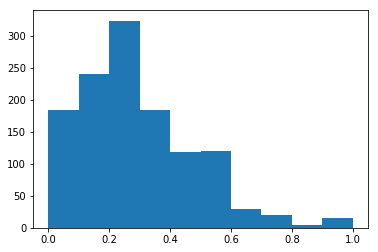

In [8]:
vals =[]
for idx, row in headlines_df.iterrows():
    tfidf_keywords = top8_keywords[idx] 
    title_generated_words = word_tokenize(row['title_generated'].lower())
    keywords = [stemmer.stem(word) for word in tfidf_keywords]
    title_generated_words = [stemmer.stem(word) for word in title_generated_words]
    vals.append(len(set(title_generated_words) & set(keywords)) / len(title_generated_words))
hist(vals, bins=10)
print(f"Rouge-1 recall of TfIdf keywords and the generated titles: \nmean: {statistics.mean(vals)}, stdev{statistics.stdev(vals)}")     

### Rouge-1 recall of TfIdf keywords and the original titles

Rouge-1 recall of TfIdf keywords and the original titles: 
mean: 0.202844842695546, stdev0.11221382078896976


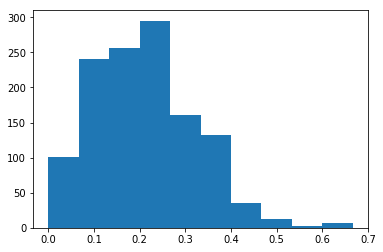

In [9]:
vals =[]
for idx, row in headlines_df.iterrows():
    tfidf_keywords = top8_keywords[idx] 
    title_original_words = word_tokenize(row['title_original'].lower())
    keywords = [stemmer.stem(word) for word in tfidf_keywords]
    title_original_words = [stemmer.stem(word) for word in title_original_words]
    vals.append(len(set(title_original_words) & set(keywords)) / len(title_original_words))
hist(vals, bins=10)
print(f"Rouge-1 recall of TfIdf keywords and the original titles: \nmean: {statistics.mean(vals)}, stdev{statistics.stdev(vals)}")     